In [5]:
# Following codes are for visualization purposes
# Run all the cells one by one in order
# The idea is to have an estimation of 3D positions of the products based on three matched bounding boxes
# This is done here by getting the intersection of backprojected bounding boxes
# Computing the rays passing through the center of bounding boxes and getting their intersection could also be used but in some cases the rays may not intersect

In [ ]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
import matplotlib.pyplot as plt
import cv2
from math import *
from itertools import combinations
from tsai_utilities import *
from itertools import product
import open3d as o3d
import camtools as ct

def ReadRGB (path):
    with open(path,"rb") as rgb:
        img = np.fromfile(rgb, np.dtype('uint8'), 320*320*3).reshape(320,320,3)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img
    
def ReadOd (path):
    with open(path,"rb") as od:
        content = od.read().decode('utf-8')
        key_value_pairs = content.split(', ')
        result_dict = {}
    for pair in key_value_pairs:
        key, value = pair.split('=')
        result_dict[key.strip()] = float(value)
    return result_dict

def show_bounding_box (img, od):
    h,w = img.shape[:2]
    x1 = int(od["x_min"]*h)
    y1 = int(od["y_min"]*w)
    x2 = int(od["x_max"]*h)
    y2 = int(od["y_max"]*w)
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    cv2.line(img, (x1, y1), (x2, y2), (255, 255, 100), 1, cv2.LINE_AA)
    cv2.line(img, (x1, y2), (x2, y1), (255, 255, 100), 1, cv2.LINE_AA)
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255),1)
    cv2.circle(img, (center_x,center_y), 2, (0,0,255),-1)
    show(img)
    return img

def get_center (od,h,w):
    x1 = int(od["x_min"]*h)
    y1 = int(od["y_min"]*w)
    x2 = int(od["x_max"]*h)
    y2 = int(od["y_max"]*w)
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    return center_x,center_y

def get_mask(img,od):
    h,w = img.shape[:-1]
    x1 = int(od["x_min"]*h)
    y1 = int(od["y_min"]*w)
    x2 = int(od["x_max"]*h)
    y2 = int(od["y_max"]*w)
    msk = np.zeros(img.shape).astype(np.uint8)
    msk=cv2.rectangle(msk, (x1,y1), (x2,y2), (255,255,255),-1)
    msk = cv2.cvtColor(msk,cv2.COLOR_BGR2GRAY)
    return msk

image_0 = cv2.imread("data/triple/0.png")
image_1 = cv2.imread("data/triple/1.png")
image_2 = cv2.imread("data/triple/2.png")
pattern_size = (9,5)
square_size = 2.5
left_offset = 4.8
right_offset = 4.8
pixel_size = pixel_size = (0.00036,0.00036)
tsai_0 = tsai_calibration_2(image_0,(9,5),square_size,left_offset,right_offset,pixel_size,save_flag=True, camera_name="cam0",debug=False)
tsai_1 = tsai_calibration(image_1,(9,6),square_size,left_offset,right_offset,pixel_size, save_flag=True, camera_name="cam1",debug=False)
tsai_2 = tsai_calibration(image_2,(9,6),square_size,left_offset,right_offset,pixel_size, save_flag=True, camera_name="cam2",debug=False)


img0 = ReadRGB("data/cam0.rgb")
img1 = ReadRGB("data/cam1.rgb")
img2 = ReadRGB("data/cam2.rgb")
h,w = img0.shape[:-1]
od0 = ReadOd ("data/cam0.od")
od1 = ReadOd ("data/cam1.od")
od2 = ReadOd ("data/cam2.od")

show_bounding_box (img0, od0)
show_bounding_box (img1, od1)
show_bounding_box (img2, od2)

center0 = get_center (od0,h,w)
center1 = get_center (od1,h,w)
center2 = get_center (od2,h,w)

In [4]:
M = [tsai_0.projMatrix,tsai_1.projMatrix,tsai_2.projMatrix]
N = len(M)
imgs= [get_mask(img0,od0),get_mask(img1,od1),get_mask(img2,od2)]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
def create_cube_grid(center, voxel_size, grid_size):
    """
    Create a cube grid centered at the specified center with custom voxel size and grid size.
    Parameters:
    - center: The center of the cube grid as a numpy array [x, y, z].
    - voxel_size: The distance between voxels.
    - grid_size: The size of the grid along each axis.
    Returns:
    - cube_grid: Open3D voxel grid.
    """
    half_size = (grid_size - 1) * voxel_size / 2
    x, y, z = np.meshgrid(
        np.linspace(center[0] - half_size, center[0] + half_size, grid_size),
        np.linspace(center[1] - half_size, center[1] + half_size, grid_size),
        np.linspace(center[2] - half_size, center[2] + half_size, grid_size),
        indexing='ij'
    )
    # Create a voxel grid using Open3D
    
    points = np.vstack((x.flatten(), y.flatten(), z.flatten())).T
    colors = np.zeros_like(points)
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(
        o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points)),
        voxel_size=voxel_size
    )
    ones = np.ones((points.shape[0]))
    points = np.c_[points,ones]
    return points,point_cloud,voxel_grid
    
# Define parameters
center = np.array([0.0, 0.0, 20.0])
voxel_size = 1
grid_size = 50
points,point_cloud,voxel_grid = create_cube_grid(center, voxel_size, grid_size)
Ks = [tsai_0.K[:,:3], tsai_1.K[:,:3], tsai_2.K[:,:3]]
EXs = [tsai_0.RT, tsai_1.RT, tsai_2.RT]
cameras = ct.camera.create_camera_frames(Ks,EXs,center_line=False,size = 2,center_ray=True)
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=8, origin=[0, 0, 0])
# Create visualization objects
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()
visualizer.add_geometry(coordinate_frame)
visualizer.add_geometry(cameras)
visualizer.add_geometry(point_cloud)
visualizer.run()
visualizer.destroy_window()

In [7]:
points2d_0 = (M[0]@points.T)
points2d_0 = ((np.floor(points2d_0 / points2d_0[2, :]).astype(np.int32)).T)[:,0:2]
mask_0 = imgs[0].astype(bool)
temp=np.zeros(mask_0.shape).astype(np.uint8)
ids_0 = []
for index,pixel in enumerate(points2d_0):
    y = pixel[1]
    x = pixel[0]
    if y>=0 and x>=0 and y<mask_0.shape[1] and x<mask_0.shape[0]:
        if mask_0[pixel[1],pixel[0]]==True:
            temp[y,x]=255
            ids_0.append(index)
temp_show = cv2.cvtColor(temp,cv2.COLOR_GRAY2BGR)
mask_0_show = cv2.cvtColor((mask_0*255).astype(np.uint8),cv2.COLOR_GRAY2BGR)
show(np.hstack((temp_show,mask_0_show,img0)))   

In [8]:
points2d_1 = (M[1]@points.T)
points2d_1 = ((np.floor(points2d_1 / points2d_1[2, :]).astype(np.int32)).T)[:,0:2]
mask_1 = imgs[1].astype(bool)
temp=np.zeros(mask_1.shape).astype(np.uint8)
ids_1 = []
for index,pixel in enumerate(points2d_1):
    y = pixel[1]
    x = pixel[0]
    if y>=0 and x>=0 and y<mask_1.shape[1] and x<mask_1.shape[0]:
        if mask_1[pixel[1],pixel[0]]==True:
            temp[y,x]=255
            ids_1.append(index)
temp_show = cv2.cvtColor(temp,cv2.COLOR_GRAY2BGR)
mask_1_show = cv2.cvtColor((mask_1*255).astype(np.uint8),cv2.COLOR_GRAY2BGR)
show(np.hstack((temp_show,mask_1_show,img1)))   

In [9]:
points2d_2 = (M[2]@points.T)
points2d_2 = ((np.floor(points2d_2 / points2d_2[2, :]).astype(np.int32)).T)[:,0:2]
mask_2 = imgs[2].astype(bool)
temp=np.zeros(mask_2.shape).astype(np.uint8)
ids_2 = []
for index,pixel in enumerate(points2d_2):
    y = pixel[1]
    x = pixel[0]
    if y>=0 and x>=0 and y<mask_2.shape[1] and x<mask_2.shape[0]:
        if mask_2[pixel[1],pixel[0]]==True:
            temp[y,x]=255
            ids_2.append(index)
temp_show = cv2.cvtColor(temp,cv2.COLOR_GRAY2BGR)
mask_2_show = cv2.cvtColor((mask_2*255).astype(np.uint8),cv2.COLOR_GRAY2BGR)
show(np.hstack((temp_show,mask_2_show,img2)))   

In [10]:
points_0 = points[ids_0][:,0:3]
colors_0 = np.zeros_like(points_0)
point_cloud_0 = o3d.geometry.PointCloud()
point_cloud_0.points = o3d.utility.Vector3dVector(points_0)
point_cloud_0.colors = o3d.utility.Vector3dVector(colors_0)

points_1 = points[ids_1][:,0:3]
colors_1 = np.ones_like(points_1)*0.5
point_cloud_1 = o3d.geometry.PointCloud()
point_cloud_1.points = o3d.utility.Vector3dVector(points_1)
point_cloud_1.colors = o3d.utility.Vector3dVector(colors_1)

points_2 = points[ids_2][:,0:3]
colors_2 = np.ones_like(points_2)*0.2
point_cloud_2 = o3d.geometry.PointCloud()
point_cloud_2.points = o3d.utility.Vector3dVector(points_2)
point_cloud_2.colors = o3d.utility.Vector3dVector(colors_2)

visualizer = o3d.visualization.Visualizer()
visualizer.create_window()
visualizer.add_geometry(coordinate_frame)
visualizer.add_geometry(cameras)
visualizer.add_geometry(point_cloud_1)
visualizer.add_geometry(point_cloud_2)
visualizer.add_geometry(point_cloud_0)
visualizer.run()
visualizer.destroy_window()

In [11]:
import collections
p0 = points_0.tolist()
p1 = points_1.tolist()
p2 = points_2.tolist()
result = []
for point in p0:
    if point in p1:
        if point in p2:
            result.append(point)

In [12]:
colors_result = np.zeros_like(result)
point_cloud_result = o3d.geometry.PointCloud()
point_cloud_result.points = o3d.utility.Vector3dVector(np.asarray(result))
point_cloud_result.colors = o3d.utility.Vector3dVector(colors_result)
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()
visualizer.add_geometry(coordinate_frame)
visualizer.add_geometry(cameras)
visualizer.add_geometry(point_cloud_result)
visualizer.run()
visualizer.destroy_window()

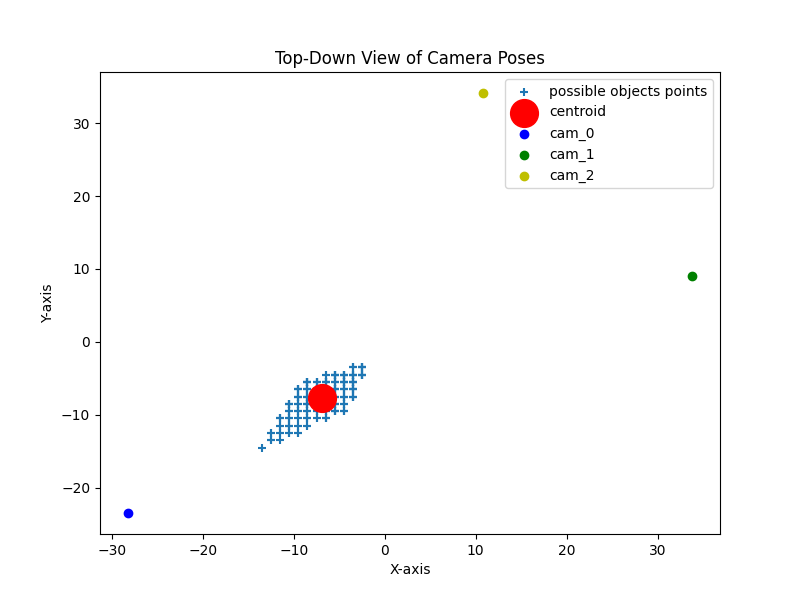

In [13]:
centroid = np.mean(np.asarray(result),axis=0).reshape(1,3)
result = np.asarray(result)
x_coords = result[:,0]
y_coords = result[:,1]
plt.close()
plt.figure(figsize = (8,6))
plt.scatter(x_coords, y_coords, marker='+', label='possible objects points')
plt.scatter(centroid.T[0], centroid.T[1], marker='o', label='centroid',color='r',s = 400)

cam_poses = [(tsai_0.invRT@np.asarray([0,0,0,1]).reshape(4,1)).T[:,0:3][0],(tsai_1.invRT@np.asarray([0,0,0,1]).reshape(4,1)).T[:,0:3][0],(tsai_2.invRT@np.asarray([0,0,0,1]).reshape(4,1)).T[:,0:3][0]]
plt.scatter(cam_poses[0].T[0], cam_poses[0].T[1], marker='o', label='cam_0',color='b')
plt.scatter(cam_poses[1].T[0], cam_poses[1].T[1], marker='o', label='cam_1',color='g')
plt.scatter(cam_poses[2].T[0], cam_poses[2].T[1], marker='o', label='cam_2',color='y')

# Customize the plot if needed
plt.title('Top-Down View of Camera Poses')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()


In [14]:
center = centroid.T.copy()
radius = 2.0 
# Generate points on the surface of the sphere 
theta = np.linspace(0, 2 * np.pi, 100) 
phi = np.linspace(0, np.pi, 50) 
theta, phi = np.meshgrid(theta, phi) 
x = center[0] + radius * np.sin(phi) * np.cos(theta) 
y = center[1] + radius * np.sin(phi) * np.sin(theta) 
z = center[2] + radius * np.cos(phi) 
# Create Open3D point cloud 
points = np.column_stack([x.flatten(), y.flatten(), z.flatten()]) 
point_cloud = o3d.geometry.PointCloud() 
point_cloud.points = o3d.utility.Vector3dVector(points) 
colors = np.ones_like(points)*0.4
point_cloud.colors = o3d.utility.Vector3dVector(colors)
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()
visualizer.add_geometry(coordinate_frame)
visualizer.add_geometry(cameras)
visualizer.add_geometry(point_cloud)
visualizer.run()
visualizer.destroy_window()

In [15]:
show(np.hstack((img0,img1,img2)))